In [1]:
from torchvision import datasets,transforms
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

import requests
import zipfile
from pathlib import Path
        

In [2]:
data_dir = Path("D:\Pytorch_data")
image_dir = data_dir/"pizza_steak_sushi"

if image_dir.is_dir():
        print("already downloaded")
else:
    image_dir.mkdir(parents=True,exist_ok=True)
    print("directory not found,downloading data...")
    with open(data_dir/"pizza_steak_sushi.zip","wb") as f:
        request = requests.get(r"https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

    with zipfile.ZipFile(data_dir/"pizza_steak_sushi.zip","r") as zip_ref:
        zip_ref.extractall(image_dir)

already downloaded


In [3]:
simple_transform = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor()])


In [4]:
train_dir = r"D:\Pytorch_data\pizza_steak_sushi\train"
test_dir = r"D:\Pytorch_data\pizza_steak_sushi\test"

train_data_simple = datasets.ImageFolder(root=train_dir,transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,transform=simple_transform)
train_data_simple[0][0].shape

torch.Size([3, 64, 64])

In [5]:
train_data_simple[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [6]:
len(train_data_simple)

225

In [7]:
import os
bs = 64
# num_workers = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,batch_size=bs,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,batch_size=bs,
                                    shuffle=True)

train_dataloader_simple,test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x16082976e50>,
 <torch.utils.data.dataloader.DataLoader at 0x160828f87f0>)

In [8]:
###train_data have 225 samples, divided into 64batches with each having 3 to 4 tensors in it
for img, label in train_dataloader_simple:
    print(img[32].shape)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


In [9]:
225 % 64    ###the last 33 batches will have 3tensors, the rest have 4tensors

33

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class TinyVGG(nn.Module):
    def __init__(self,in_shape: int,hidden_unit: int,out_shape: int) -> None:
        super().__init__()
        self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                 out_channels=hidden_unit,
                 kernel_size=(3,3),
                 stride=1,
                 padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_unit,
                 out_channels=hidden_unit,
                 kernel_size=3,
                 stride=1,
                 padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                    stride=2)
        )
        self.conv_block2 = nn.Sequential(
        nn.Conv2d(hidden_unit,
                hidden_unit,
                3,
                1,
                1),
        nn.ReLU(),
        nn.Conv2d(hidden_unit,
                 hidden_unit,
                 3,
                 1,
                 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_unit*16*16,
                 out_shape)
        )

    def forward(self,x:torch.Tensor):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x
    
torch.manual_seed(42)
model_0 = TinyVGG(in_shape=3,hidden_unit=10,out_shape=len(train_data_simple.classes)).to(device)

model_0
        

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [12]:
img_batch,label_batch = next(iter(train_dataloader_simple))
img_single,label_single = img_batch[0].unsqueeze(dim=0),label_batch[0]

model_0.eval()
with torch.inference_mode():
    y_pred = model_0(img_single.to(device))
    
print(f"logits: {y_pred}\n")
print(f"probability: {torch.softmax(y_pred,dim=1)}\n")
print(f"prediction label: {torch.argmax(torch.softmax(y_pred,dim=1),dim=1)}\n")
print(f"truth label: {label_single}")

logits: tensor([[0.0578, 0.0634, 0.0352]], device='cuda:0')

probability: tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

prediction label: tensor([1], device='cuda:0')

truth label: 2


In [13]:
try: 
    from torchinfo import summary
except:
    !pip install torchinfo
    from torchinfo import summary 

In [14]:
summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [15]:
device

'cuda'

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),lr=0.1)

In [17]:
from torchmetrics import Accuracy
from tqdm.auto import tqdm

C:\Users\pouya\AppData\Roaming\Python\Python39\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [18]:
def train_step(model,train_dataloader,criterion,
               optimizer,device = device):
    """
    training a model
    
    args:
    model:
    train_dataloader:
    criterion:
    optimizer:
    device = device
    """
    model.train()
    
    train_loss = 0
    train_acc = 0
    for batch, (X,y) in enumerate(train_dataloader):
               
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
        
        loss = criterion(y_pred,y)
        train_loss += loss.item()
        
        acc = (y_pred_class == y).sum().item() / len(y_pred)        
#         acc = Accuracy(y_pred,y)
        train_acc += acc 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    
    return train_loss, train_acc
        

In [19]:
train_step(model_0, train_dataloader_simple, criterion, optimizer)

(1.1035282909870148, 0.30622632575757575)

In [20]:
def test_step(model, dataloader, criterion, optimizer):
    
    model.eval()
    
    test_loss = 0
    test_acc = 0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        
        y_test = model(X)
        y_test_class = torch.argmax(torch.softmax(y_test,dim=1),dim=1)
        
        loss = criterion(y_test, y)
        test_loss += loss.item()
        
        acc = torch.eq(y_test_class,y).sum().item()
        test_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    test_loss /= len(dataloader)
    test_acc /=  len(dataloader)
    
    return test_loss, test_acc

In [21]:
test_step(model_0, test_dataloader_simple, criterion, optimizer)

(1.104851484298706, 15.5)

In [22]:
next(model_0.parameters()).device


device(type='cuda', index=0)

In [23]:
from collections import defaultdict


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
          criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs:int = 5):
    
#     results = {"train_loss": [],
#         "train_acc": [],
#         "test_loss": [],
#         "test_acc": []
#     }
    
    results = defaultdict(list)
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model,train_dataloader,criterion,optimizer)
        test_loss,test_acc = test_step(model,test_dataloader,criterion,optimizer)
        
        print(
        f"Epoch: {epoch+1} | train_loss: {train_loss:0.4f} | train_acc: {train_acc:0.4f} | test_loss: {test_loss:0.4f} | test_acc: {test_acc:0.4f} ")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results
    

In [24]:
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_epochs = 5

model_0 = TinyVGG(3,10,len(train_data_simple.classes)).to(device)
                  
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()                  
start_time = timer()

model_0_results = train(model_0,train_dataloader_simple,test_dataloader_simple,criterion, optimizer,num_epochs)

end_timer = timer()

print(f"total time took {end_timer-start_time} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1068 | train_acc: 0.3262 | test_loss: 1.1094 | test_acc: 12.5000 
Epoch: 2 | train_loss: 1.1014 | train_acc: 0.3255 | test_loss: 1.0949 | test_acc: 15.5000 
Epoch: 3 | train_loss: 1.1039 | train_acc: 0.3253 | test_loss: 1.0875 | test_acc: 15.5000 
Epoch: 4 | train_loss: 1.1020 | train_acc: 0.3143 | test_loss: 1.0889 | test_acc: 15.5000 
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.3179 | test_loss: 1.0845 | test_acc: 15.5000 
total time took 9.6562749 seconds


In [25]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [26]:
!nvidia-smi

Sat Sep 16 14:21:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.25       Driver Version: 522.25       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   42C    P2    29W / 180W |   1771MiB /  6144MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [27]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [28]:
model_0_results

defaultdict(list,
            {'train_loss': [1.106753408908844,
              1.1013735234737396,
              1.1039060354232788,
              1.1019702851772308,
              1.0985010862350464],
             'train_acc': [0.3262310606060606,
              0.3255208333333333,
              0.32528409090909094,
              0.3142755681818182,
              0.31794507575757575],
             'test_loss': [1.109402596950531,
              1.0948657989501953,
              1.0875425934791565,
              1.0889161825180054,
              1.0844762325286865],
             'test_acc': [12.5, 15.5, 15.5, 15.5, 15.5]})

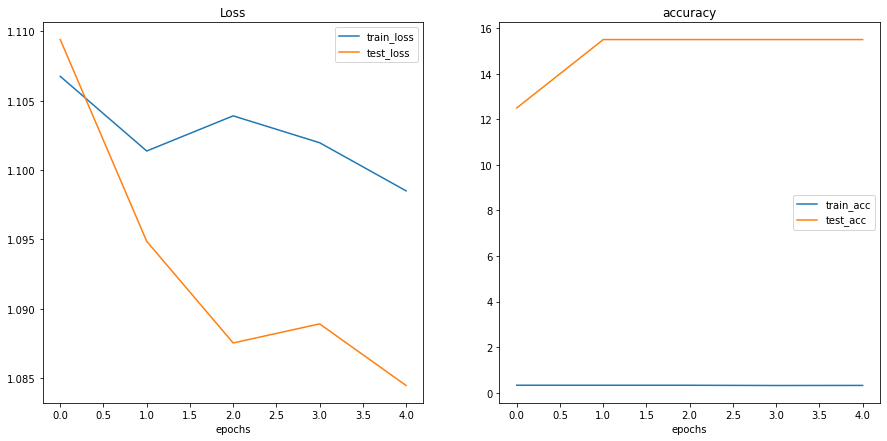

In [29]:
from typing import Dict,List,Tuple
import matplotlib.pyplot as plt

def plot_loss_curves(results:Dict[str,List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    acc = results["train_acc"]
    test_acc = results["test_acc"]
    
    epochs = range(len(loss))
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
#     plt.xscale("log")
#     plt.yscale("log")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("accuracy")
    plt.xlabel("epochs")
#     plt.xscale("log")
#     plt.yscale("log")
    plt.legend();
    

plot_loss_curves(model_0_results)

In [30]:
len(train_dataloader_simple),len(train_data_simple)

(4, 225)

In [31]:
next(iter(train_dataloader_simple))[0].shape

torch.Size([64, 3, 64, 64])

In [32]:
train_dir = image_dir/"train"
test_dir = image_dir/"test"

In [33]:
# Create training transform with TrivialAugment
train_transform_trivial_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [34]:
train_data_augmented = datasets.ImageFolder(root=train_dir,transform =train_transform_trivial_aug)
test_data_simple = datasets.ImageFolder(root=test_dir,transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: D:\Pytorch_data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: D:\Pytorch_data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [35]:
import os
BATCH_SIZE = 32
# NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x1611983f5e0>,
 <torch.utils.data.dataloader.DataLoader at 0x16124653fd0>)

In [36]:
next(iter(train_dataloader_augmented))[1]

tensor([2, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 0, 2, 1, 2, 1, 2, 0, 2,
        0, 2, 1, 2, 2, 0, 2, 0])

In [37]:
len(train_data_augmented.classes)

3

In [38]:
model_1 = TinyVGG(
    in_shape=3,
    hidden_unit=10,
    out_shape=len(train_data_augmented.classes)
    ).to(device)

model_1

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [39]:
summary(model_1)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      7,683
Total params: 10,693
Trainable params: 10,693
Non-trainable params: 0

In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=0.001)

start_time = timer()

model_1_results = train(model_1,train_dataloader_augmented,test_dataloader_simple,criterion,optimizer)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1007 | train_acc: 0.2734 | test_loss: 1.1125 | test_acc: 8.3333 
Epoch: 2 | train_loss: 1.0978 | train_acc: 0.3047 | test_loss: 1.0891 | test_acc: 8.3333 
Epoch: 3 | train_loss: 1.1116 | train_acc: 0.2773 | test_loss: 1.0804 | test_acc: 10.3333 
Epoch: 4 | train_loss: 1.0913 | train_acc: 0.4102 | test_loss: 1.0860 | test_acc: 11.3333 
Epoch: 5 | train_loss: 1.0886 | train_acc: 0.3281 | test_loss: 1.0628 | test_acc: 11.6667 
Total training time: 10.560 seconds


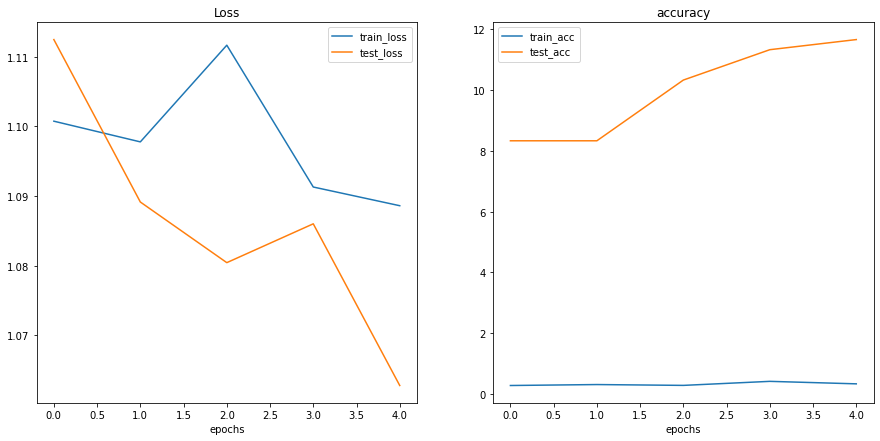

In [41]:
plot_loss_curves(model_1_results)

In [42]:
model_1_results

defaultdict(list,
            {'train_loss': [1.100745603442192,
              1.097776159644127,
              1.1116497069597244,
              1.091300144791603,
              1.0886167883872986],
             'train_acc': [0.2734375,
              0.3046875,
              0.27734375,
              0.41015625,
              0.328125],
             'test_loss': [1.1124574343363445,
              1.0891469319661458,
              1.0804461240768433,
              1.0860188007354736,
              1.0628161430358887],
             'test_acc': [8.333333333333334,
              8.333333333333334,
              10.333333333333334,
              11.333333333333334,
              11.666666666666666]})

In [43]:
torch.manual_seed(2)
a = torch.randn(2,2)
b = torch.randn(2,2)
a,b

(tensor([[ 0.3923, -0.2236],
         [-0.3195, -1.2050]]),
 tensor([[ 1.0445, -0.6332],
         [ 0.5731,  0.5409]]))

In [44]:
torch.cat([a,b],dim=0)

tensor([[ 0.3923, -0.2236],
        [-0.3195, -1.2050],
        [ 1.0445, -0.6332],
        [ 0.5731,  0.5409]])

In [45]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df.merge(model_1_df,how="outer")

,train_loss,train_acc,test_loss,test_acc
0,1.106753,0.326231,1.109403,12.500000
1,1.101374,0.325521,1.094866,15.500000
2,1.103906,0.325284,1.087543,15.500000
3,1.101970,0.314276,1.088916,15.500000
4,1.098501,0.317945,1.084476,15.500000
5,1.100746,0.273438,1.112457,8.333333
6,1.097776,0.304688,1.089147,8.333333
7,1.111650,0.277344,1.080446,10.333333
8,1.091300,0.410156,1.086019,11.333333
9,1.088617,0.328125,1.062816,11.666667


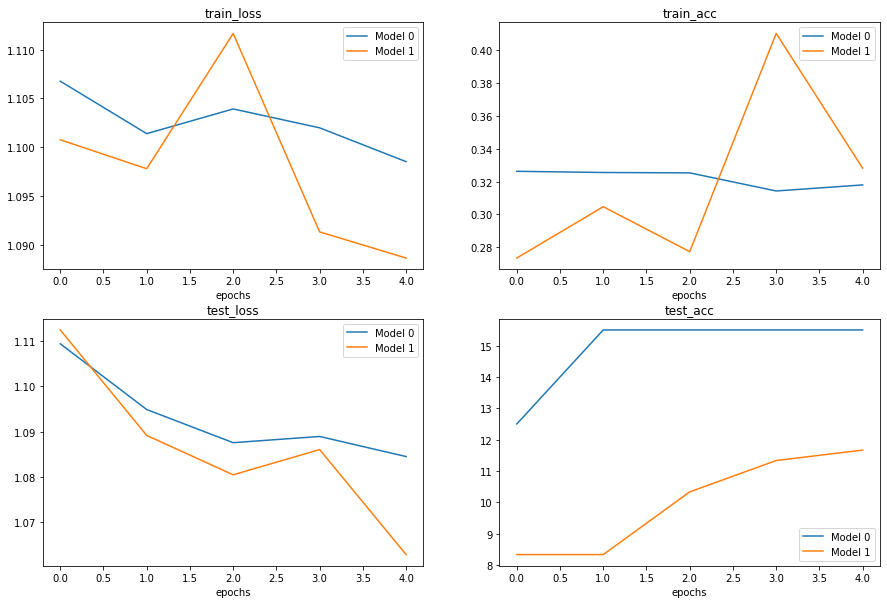

In [46]:
epochs = range(len(model_0_df))

fig,ax = plt.subplots(2,2,figsize=(15,10))

ax[0,0].plot(epochs, model_0_df["train_loss"], label="Model 0")
ax[0,0].plot(epochs, model_1_df["train_loss"], label="Model 1")
ax[0,0].set_title("train_loss")
ax[0,0].set_xlabel("epochs")
ax[0,0].legend()


ax[0,1].plot(epochs, model_0_df["train_acc"], label="Model 0")
ax[0,1].plot(epochs, model_1_df["train_acc"], label="Model 1")
ax[0,1].set_title("train_acc")
ax[0,1].set_xlabel("epochs")
ax[0,1].legend()

ax[1,0].plot(epochs, model_0_df["test_loss"], label="Model 0")
ax[1,0].plot(epochs, model_1_df["test_loss"], label="Model 1")
ax[1,0].set_title("test_loss")
ax[1,0].set_xlabel("epochs")
ax[1,0].legend()

ax[1,1].plot(epochs, model_0_df["test_acc"], label="Model 0")
ax[1,1].plot(epochs, model_1_df["test_acc"], label="Model 1")
ax[1,1].set_title("test_acc")
ax[1,1].set_xlabel("epochs")
ax[1,1].legend();

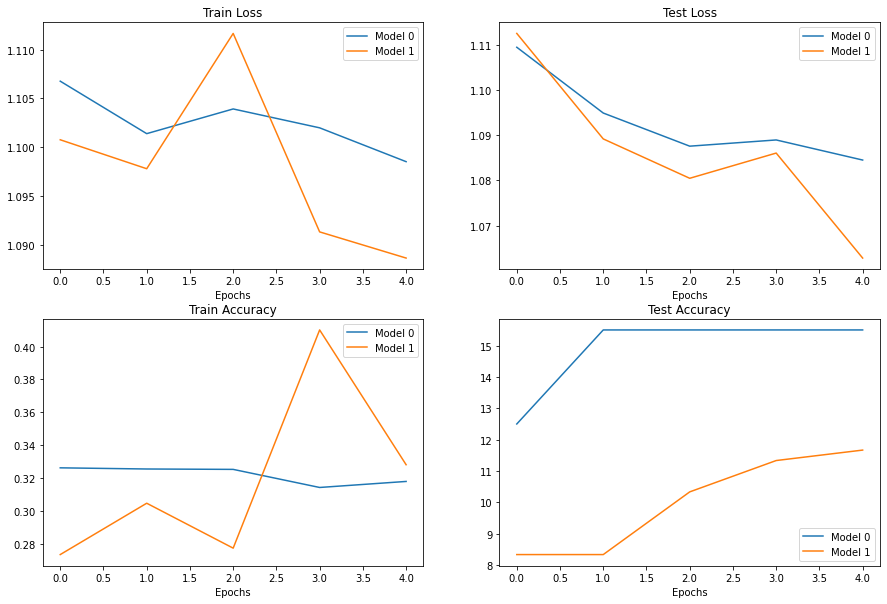

In [47]:
##can also plot like this

# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

In [48]:
model_1_results

defaultdict(list,
            {'train_loss': [1.100745603442192,
              1.097776159644127,
              1.1116497069597244,
              1.091300144791603,
              1.0886167883872986],
             'train_acc': [0.2734375,
              0.3046875,
              0.27734375,
              0.41015625,
              0.328125],
             'test_loss': [1.1124574343363445,
              1.0891469319661458,
              1.0804461240768433,
              1.0860188007354736,
              1.0628161430358887],
             'test_acc': [8.333333333333334,
              8.333333333333334,
              10.333333333333334,
              11.333333333333334,
              11.666666666666666]})

In [49]:
# Download custom image
import requests

# Setup custom image path
custom_img_path = data_dir / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_img_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_img_path} already exists, skipping download.")

D:\Pytorch_data\04-pizza-dad.jpeg already exists, skipping download.


In [50]:
import torchvision
custom_image_uint8 = torchvision.io.read_image(str(custom_img_path))

print(f"custom image tensor:\n {custom_image_uint8}\n")
print(f"custom image tensor:\n {custom_image_uint8.shape}\n")
print(f"custom image tensor:\n {custom_image_uint8.dtype}")


custom image tensor:
 tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

custom image tensor:
 torch.Size([3, 4032, 3024])

custom image 

In [51]:
custom_image = torchvision.io.read_image(str(custom_img_path))
custom_image = custom_image / 255
custom_image

tensor([[[0.6039, 0.6863, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6549, 0.7059,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6706,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7412, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7098, 0.7608,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7255,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4157, 0.4078, 0.4000],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4118, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4588, 0.5412, 0.5686,  ..., 0.0667, 0.0549, 0.0392],
         [0.4275, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

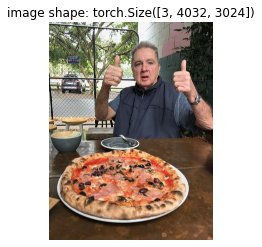

In [52]:
##let's test in matplot first
import matplotlib.pyplot as plt

plt.imshow(custom_image.permute(1,2,0))
plt.title(f"image shape: {custom_image.shape}")
plt.axis(False);

In [53]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))])

custom_image_transformed = custom_image_transform(custom_image)
custom_image.shape,custom_image_transformed.shape

C:\Users\pouya\AppData\Roaming\Python\Python39\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([3, 4032, 3024]), torch.Size([3, 64, 64]))

In [54]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [55]:
custom_image_pred

tensor([[-0.0538, -0.1149,  0.0545]], device='cuda:0')

In [56]:
custom_img_pred_probs = torch.softmax(custom_image_pred,dim=1)
custom_img_pred_label = torch.argmax(custom_img_pred_probs,dim=1)
custom_img_pred_label

tensor([2], device='cuda:0')

In [57]:
class_names = train_data_augmented.classes
class_names

['pizza', 'steak', 'sushi']

In [58]:
class_names[custom_img_pred_label]

'sushi'

In [59]:
###almost equal weights, could have also been pizza or even steak
custom_img_pred_probs

tensor([[0.3273, 0.3079, 0.3648]], device='cuda:0')

In [60]:
##predict another image
import requests
from pathlib import Path

custom_img_path = data_dir/"dominos-pizza.jpg"

if not custom_img_path.is_file():
    with open(custom_img_path, "wb") as f:
        request = requests.get(r'https://www.digitaltrends.com/wp-content/uploads/2019/03/dominos-pizza.jpg?fit=720%2C480&p=1')
        print("downloading custom image")
        f.write(request.content)
else:
    print(f"{custom_img_path }already exist, skipping download")


D:\Pytorch_data\dominos-pizza.jpgalready exist, skipping download


In [61]:
custom_image = torchvision.io.read_image(str(custom_img_path))
custom_image.shape,custom_image.dtype

(torch.Size([3, 480, 720]), torch.uint8)

In [62]:
custom_image = torchvision.io.read_image(str(custom_img_path)).type(torch.float32)
custom_image = custom_image / 255
custom_image

tensor([[[0.3412, 0.3451, 0.3569,  ..., 0.4588, 0.4588, 0.4510],
         [0.3490, 0.3490, 0.3529,  ..., 0.4588, 0.4549, 0.4431],
         [0.3490, 0.3490, 0.3490,  ..., 0.4510, 0.4431, 0.4314],
         ...,
         [0.7255, 0.7412, 0.7451,  ..., 0.9412, 0.9412, 0.9529],
         [0.7412, 0.7529, 0.7490,  ..., 0.9098, 0.9098, 0.9294],
         [0.7529, 0.7608, 0.7490,  ..., 0.9255, 0.9412, 0.9686]],

        [[0.3412, 0.3451, 0.3451,  ..., 0.3765, 0.3765, 0.3686],
         [0.3373, 0.3373, 0.3412,  ..., 0.3765, 0.3725, 0.3608],
         [0.3412, 0.3412, 0.3412,  ..., 0.3686, 0.3608, 0.3490],
         ...,
         [0.5608, 0.5765, 0.5804,  ..., 0.8039, 0.8039, 0.8157],
         [0.5765, 0.5882, 0.5843,  ..., 0.7725, 0.7725, 0.7922],
         [0.5882, 0.5961, 0.5843,  ..., 0.7882, 0.8039, 0.8314]],

        [[0.3020, 0.3059, 0.3098,  ..., 0.3098, 0.3098, 0.2941],
         [0.3020, 0.3020, 0.3059,  ..., 0.3098, 0.3059, 0.2941],
         [0.2941, 0.2941, 0.2941,  ..., 0.3020, 0.2941, 0.

Text(0.5, 1.0, 'image shape: torch.Size([3, 480, 720])')

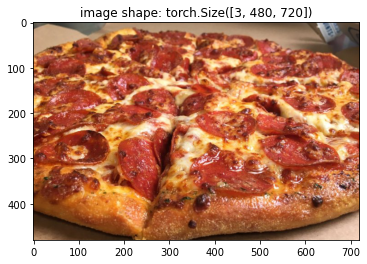

In [63]:
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"image shape: {custom_image.shape}")

In [64]:
custom_tranform = transforms.Compose([
    transforms.Resize((64,64))
])
custom_image_transformed = custom_tranform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [65]:
custom_img_transformed_with_batch_size = custom_image_transformed.unsqueeze(0)
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_img_transformed_with_batch_size.to(device))
    

In [66]:
custom_img_probs = torch.softmax(custom_image_pred,dim=1)
custom_img_labels = torch.argmax(custom_img_probs,dim=1)
custom_img_labels,custom_img_probs

(tensor([2], device='cuda:0'),
 tensor([[0.3313, 0.3019, 0.3668]], device='cuda:0'))

In [67]:
class_names = train_data_augmented.classes
class_names[custom_img_labels]

'sushi'

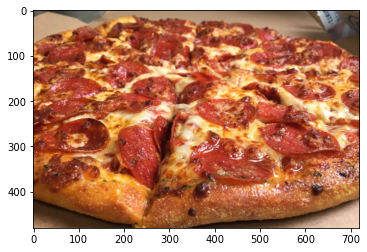

In [68]:
plt.imshow(custom_image.permute(1,2,0))

In [69]:
def pred_and_plot(model,
                 image_path,
                 transform = None,
                 class_names=None,
                 device: torch.device =device):
    
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    #divide pixels by 255 to get them between [0,1]
    target_image = target_image / 255
    
    if transform:
        target_image = transform(target_image)
        
    target_image = target_image.unsqueeze(0) #--> from CHW to NCHW
#     model.to(device)
    
    with torch.inference_mode():
        target_image_pred = model(target_image.to(device))
        target_image_probs = torch.softmax(target_image_pred,dim=1)
        target_image_pred_label = torch.argmax(target_image_probs, dim=1)
        
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"pred: {class_names[target_image_pred_label]} | probs: {target_image_probs.max():0.3f}"
    else:
        title = f"pred: {target_image_pred_label} | probs: {target_image_probs.max():0.3f}"
        
    plt.title(title)
    
    plt.axis(False);
        

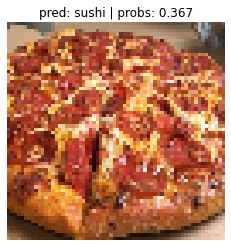

In [70]:
pred_and_plot(model_1,
             custom_img_path,
             custom_tranform,
             class_names)

In [77]:
model_1.eval()
with torch.inference_mode():
    pred_labels = []
    for X,y in tqdm(test_dataloader_simple,desc="making predictions"):
        X,y = X.to(device), y.to(device)
        logit = model_1(X)
        pred_label = torch.softmax(logit,dim=1).argmax(dim=1)
        
        pred_labels.append(pred_label.cpu())
        
pred_labels_tensor = torch.cat(pred_labels)
pred_labels_tensor
    

making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [100]:
test_truth = [y for X,y in test_dataloader_simple]
test_truth = torch.cat(test_truth)
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

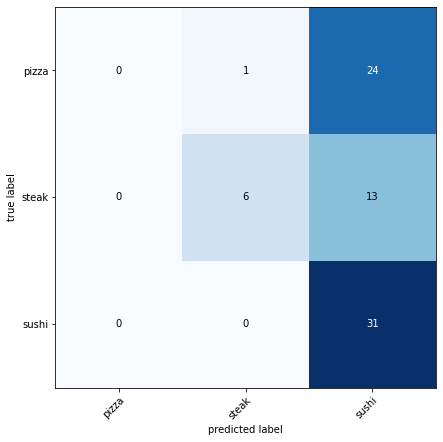

In [101]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes= len(class_names), task="multiclass")
confmat_tensor = confmat(pred_labels_tensor,
                        test_truth)   

fix, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,7)
    )